In [ ]:
install.packages('pROC')
install.packages('ROCR')
install.packages('Epi')
library(pROC)
library(ROCR)
library(Epi)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Simulation following David Hand's
# Measuring classifier performance:
# a coherent alternative to the area under the ROC curve

set.seed(561)

cost0 = 1   # Cost of mis-classifying a normal as having cancer in million $
cost1 = 10   # Cost of mis-classifying a cancer patient as normal (death?)

b = cost0 + cost1
c = cost0/(b)

n = 7000    # Total cases
pi0 =.8     # Percentage of normal
pi1 =.2     # Percentage of disease

# Actual values of the test for normals and disease (D higher test values)
testA_Normals = rnorm(n*pi0, mean=3, sd=1)
testA_Sick = rnorm(n*pi1, 6, 1)

In [ ]:
# Determining a threshold based on cost
# arg t min {Loss = cost0 * (1 - pnorm(t,3,1)) * pi0 +
#            cost1 * pnorm(t,6,1) * pi1}

t = seq(0,10,0.0001)
loss <- cost0 * (1 - pnorm(t,3,1)) * pi0 + cost1 * pnorm(t,6,1) * pi1
Threshold = data.frame(t,loss)[which(loss==min(loss)),]$t

(LOSS = cost0 * (1 - pnorm(Threshold,3,1)) * pi0 + cost1 * pnorm(Threshold,6,1) * pi1)

[1] 0.1639095

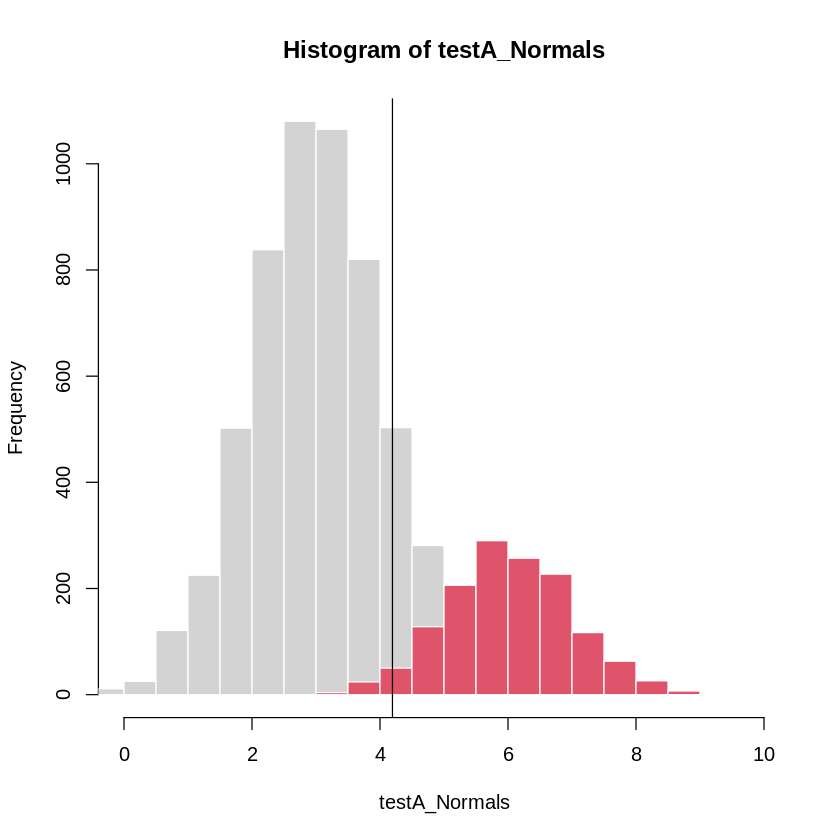

In [ ]:
hist(testA_Normals,border=F, xlim=c(0,10))
hist(testA_Sick,col=2,border=F, add=T)

abline(v=Threshold)

In [ ]:
c
pi1 * dnorm(Threshold,6,1) / (pi0 * dnorm(Threshold,3,1) + pi1 * dnorm(Threshold,6,1))
#P(1|T) = P(1,T) / P(T) = P(T|1) x P(1) / [P(T|1) x P(1) + P(T|0) x P(0)]
r = pnorm(Threshold,6,1,lower.tail = F) * pi1
s = pnorm(Threshold,3,1,lower.tail = F) * pi0
r/(r+s)

[1] 0.09090909

[1] 0.09091659

[1] 0.6749524

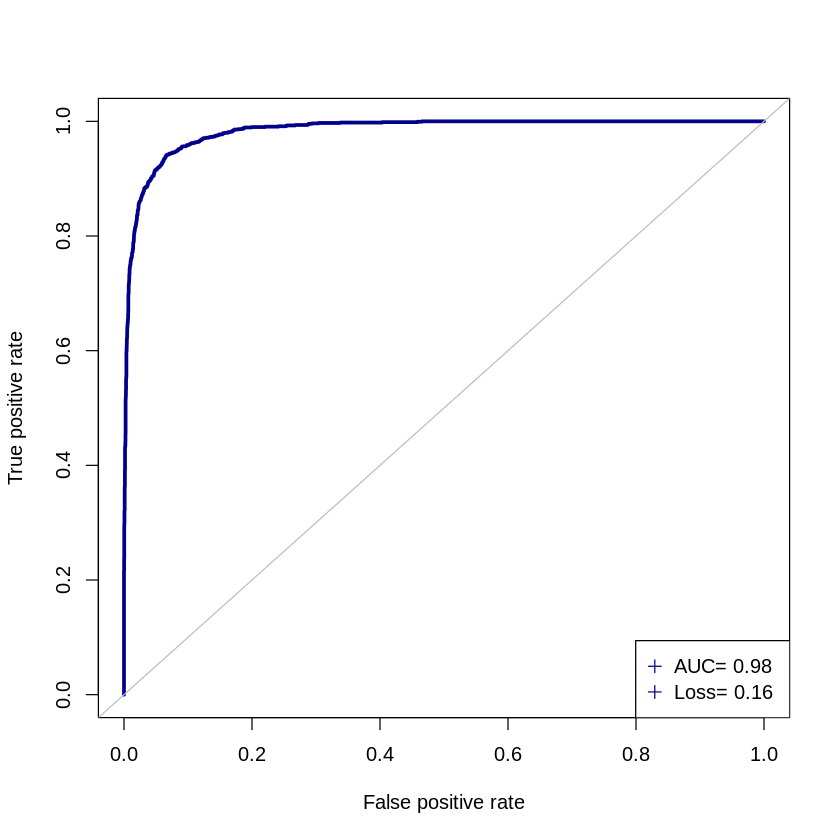

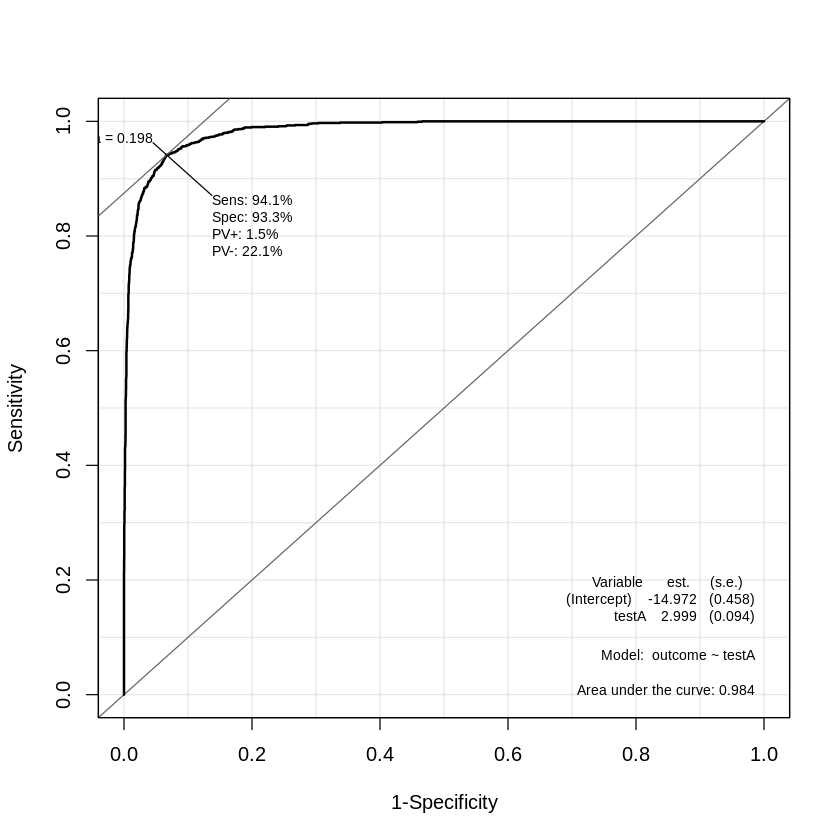

[1] 0.1979677

,sens,spec,pvp,pvn,lr.eta
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.197967678451663,0.9414286,0.9333929,0.01544547,0.2205795,0.1979677


(Intercept)       testA 
 -14.972459    2.999033

(Intercept)       testA 
 -14.972459    2.999033

(Intercept) 
 0.08372988

[1] 0.08380077

1 
0.08372988

1 
5.790258

(Intercept) 
   5.458928

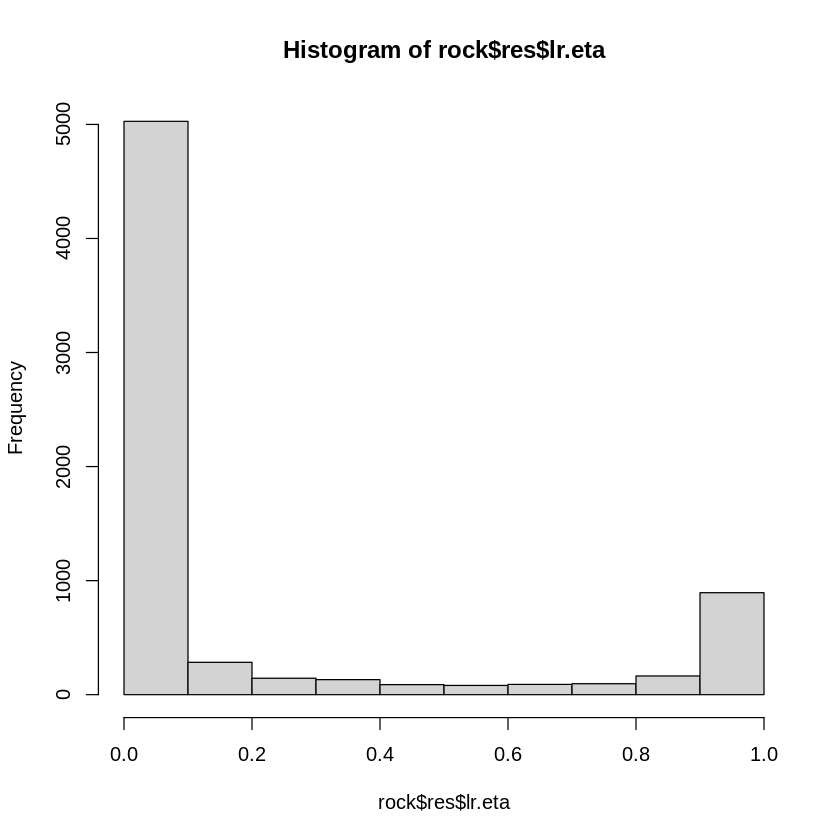

In [ ]:
# Data frame with all cases and outcomes:
data = data.frame(outcome=as.factor(c(rep(0,n*pi0),rep(1,n*pi1))),
                  testA=c(testA_Normals,testA_Sick))

# Generating ROC curves:

pred <- prediction(data$testA, data$outcome)
perf <- performance(pred, "tpr", "fpr")
# performance metrics TPR: True Positive Ratio FPR: False Positive Ratio
plot(perf, col = "blue4", lwd=3)
abline(0, 1, col = "grey")
auc <- performance(pred, "auc")
legend("bottomright",
       c(paste("AUC=",round(as.numeric(auc@y.values), digits = 2)),
         paste("Loss=",round(LOSS,2))), col = c("blue4"), pch = c(3),
       )

# Alternative ROC with "optimal" score:
rock = ROC(form = outcome ~ testA, data=data, plot = "ROC", MX = T)

# Histogram of score values:
hist(rock$res$lr.eta)

# ROC selected "optimal" value to minimize sum sensitivity and specificity:
(machineT = as.numeric(names(which.max(rowSums(rock$res[, c("sens", "spec")])))))

# Actual values:
rock$res[which.max(rowSums(rock$res[, c("sens", "spec")])),]

# Parallel generation of the logistic regression:
logireg = glm(outcome~testA, data, family="binomial")
logireg$coefficients

# Same as the coefficients in the ROC analysis:
rock$lr$coefficients

# Score corresponding to the chosen Threshold:
(score.Thresh <- exp(logireg$coefficients[1]+
      Threshold*logireg$coefficients[2])/(1+
                          exp(logireg$coefficients[1]+
                              Threshold*logireg$coefficients[2])))

# Determining which score is closest to the chosen (Threshold):
rock$diff <- abs(rock$res$lr.eta - score.Thresh)
(Tval = rock$res[which.min(rock$diff),]$lr.eta)

#...which can be done exactly with predict():
nd = data.frame(testA = Threshold)
(Tval=predict.glm(logireg, newdata = nd, type='response'))

# The approximate cutoff value determined manually:
(log(1/Tval - 1) - logireg$coefficients[1])/logireg$coefficients[2]

# The cutoff value determined by ROC curve:
(log(1/machineT - 1) - logireg$coefficients[1])/logireg$coefficients[2]
